In [140]:
using Glob
using NPZ
using Plots
using StatsBase
using EvalMetrics
using locaTE
# dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-BFStrange/dyn-BFStrange-1000-*");
# dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-SW/dyn-SW-1000-*");
dirs = Glob.glob("../../data/simulated/Curated_noise/GSD/GSD-1000-*");
# dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-BFStrange/dyn-BFStrange-1000-*");
what = "velo_dot"

"velo_dot"

In [141]:
# dropout too high can cause locaTE to crash it seems
dirs = dirs[.!contains.(dirs, "_dropout_0.75")];

In [142]:
sim_name = split(split(split(dirs[1], r"-1$")[1], "/")[end], r"-[0-9|10]")[1]

"GSD"

In [143]:
dropout = map(x -> parse(Float64, split(split(x, "-")[end], "_")[5]), dirs);
noise = map(x -> parse(Float64, split(split(x, "-")[end], "_")[3]), dirs);
sim = map(x -> parse(Int, split(split(x, "-")[end], "_")[1]), dirs);

In [144]:
# ground truth
J = abs.(permutedims(npzread(joinpath(dirs[1], "J.npy")), [1, 3, 2]));
J_static = mean(J; dims = 1)[1, :, :] .> 0.05;
if what == "undir" J_static = locaTE.symm(J_static) end

In [145]:
# baseline
baseline_static = mean(J_static)

0.08033240997229917

In [146]:
# load 
path = [joinpath(Glob.glob(joinpath(d, "locate_output_*"))[1], "G_static_cdf_$(what).npy") for d in dirs]
# path = [joinpath(Glob.glob(joinpath(d, "locate_output_*"))[1], "G_static_cdf_undir.npy") for d in dirs]
G_static_all = [try npzread(x) catch nothing end for x in path];
X_all = [npzread(joinpath(d, "X.npy")) for d in dirs];

sim_vals = sort(unique(sim));
noise_vals = sort(unique(noise));
dropout_vals = sort(unique(dropout));

y = zeros(length(sim_vals), length(noise_vals), length(dropout_vals))
for (i, (_sim, _noise, _dropout)) in enumerate(zip(sim, noise, dropout))
    y[sim_vals .== _sim, noise_vals .== _noise, dropout_vals .== _dropout] .= try au_prcurve(vec(J_static), vec(G_static_all[i])) / baseline_static catch e NaN end
end

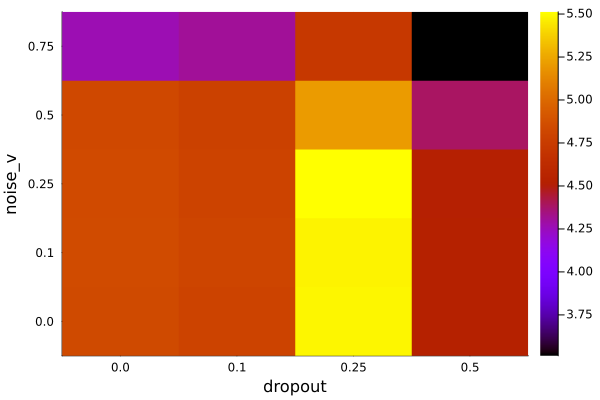

In [147]:
heatmap(mean(y; dims = 1)[1, :, :]; xticks = (1:length(dropout_vals), dropout_vals), yticks = (1:length(noise_vals), noise_vals), xlabel = "dropout", ylabel = "noise_v", cmap = :gnuplot)

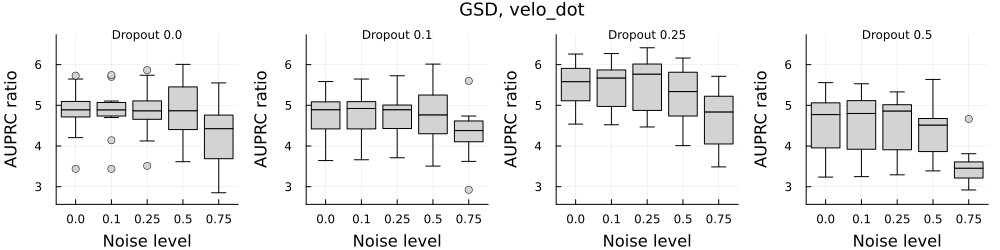

In [148]:
using StatsPlots
plt=plot([boxplot(y[:, :, k], xticks = (1:length(noise_vals), noise_vals), title = "\nDropout $(dropout_vals[k])", titlefontsize = 8, ylim = (minimum(y)*0.9, maximum(y)*1.05), 
                    legend = nothing, xlabel = "Noise level", color = :lightgrey, bottommargin = 5*Plots.mm, leftmargin = 5*Plots.mm) for k = 1:length(dropout_vals)]...; 
                layout = (1, 4), size = (1_000, 250), ylabel = "AUPRC ratio", plot_title = "$(sim_name), $(what)", plot_titlefontsize = 12)
savefig("$(sim_name)_$(what)_static_noise_dropout_boxplots.pdf")
plt

In [149]:
# include("comparisons/process_outputs_util.jl")
# 
# using CSV, DataFrames, LinearAlgebra
# Ng = size(J, 2)
# 
# # dirs = Glob.glob("../../data/simulated/Synthetic_2000_noise/dyn-SW/dyn-SW-2000-*_noise_0_*");
# dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-SW/dyn-SW-1000-*_noise_0_*");
# # dirs = Glob.glob("../../data/simulated/Synthetic_1000_noise/dyn-BFStrange/dyn-BFStrange-1000-*_noise_0_*");
# # path = [joinpath(d, "genie3/A.csv") for d in dirs]
# # path = [joinpath(d, "sincerities/A.txt") for d in dirs]
# # path = [joinpath(d, "scribe/G_scribe.npy") for d in dirs]
# path = [joinpath(d, "G_pidc.npy") for d in dirs]
# G_pidc_all = [try npzread(x) catch nothing end for x in path];
# # G_pidc_all = [try process_scribe(x, J_static)[1] catch nothing end for x in path];
# 
# dropout = map(x -> parse(Float64, split(split(x, "-")[end], "_")[5]), dirs);
# sim = map(x -> parse(Int, split(split(x, "-")[end], "_")[1]), dirs);
# 
# y = zeros(length(sim_vals), length(dropout_vals))
# for (i, (_sim, _dropout)) in enumerate(zip(sim, dropout))
#     y[sim_vals .== _sim, dropout_vals .== _dropout] .= try au_prcurve(vec(J_static), vec(G_pidc_all[i])) catch e NaN end
# end
# 
# boxplot(y; ylim = (0, 1))

In [558]:
# using EvalMetrics
# plt=plot()
# for (i, (s, t)) in enumerate(zip(noise, dropout))
#     try
#         prplot!(vec(J_static), vec(G_static_all[i]); label = "noise = $s, dropout = $t")
#     catch 
#     end
# end
# plt

In [525]:
# length(unique(noise))

In [526]:
# plot([try heatmap(g; title = "s = $s, t= $t") catch e plot() end for (g, s, t) in zip(G_static_all, noise, dropout)]...; layout = (length(unique(noise)), length(unique(dropout))), colorbar = false, size = (1000, 1000))